# LightHearted: Tutorial

This notebook presents a walkthrough of how to use the LightHearted framework to create a lighting design. For this, we use the design employed in a concert with the Aarhus Symphony Orchestra (ASO) for a performance of Tchaikovsky's Romeo and Juliet Fantasy Overture. The script containing this can be found in the examples folder . By the end of this tutorial you should hopefully be familiar with the use of the five main objects used in a LightHearted workflow:

- FIFOBuffer - Used to contain and process ECG signals
- LightingArray - Used to define a lighting group and send them commands
- MappingArray - Used to contain and reduce data to be mapped from multiple ECG devices and derive spatial expansions that can be mapped to LightingArrays
- ContinuousMapper - Used to define the relationship between a MappingArray and a LightingArray
- TriggerMapper - Used to define event based triggers between FIFOBuffers and LightingArrays

## 1. Basics

### 1.1 Workflow

The general workflow for LightHearted is as follows:

1. ECG signals are transported over OSC and received in a script. For each signal, a first-in-first-out (FIFO) buffer is instanced.
2. Optional chains of transforms are applied to each FIFOBuffer, and placed into new instances of FIFOBuffers (e.g. filtering, QRS extraction).
3. Signal or transformed buffers can be assigned to instances of MappingArrays. These take multiple FIFOBuffers, with their position in the array corresponding to a spatial position. Each buffer is reduced to a single value using a chain of functions (e.g. mean, the newest value in the array).
4. The MappingArray can be used to generate spatial expansions, that is expanding the MappingArray to match the shape of a LightingArray. This can be done through a user-defined function (e.g. linear interpolation, filling the expansion with set values). A single MappingArray can generate multiple spatial expansions if the data is to be used to generate lighting across multiple lighting groups.
5. Groups of lighting fixtures are defined as LightingArray objects. If interpolations are to be used to generate spatial expansions in the MappingArray, anchor positions in the LightingArray can also be defined. These correspond to the spatial positions of the values in the MappingArray before expansion.
6. ContinuousMappers can be instanced to define the relationship between the MappingArrays/spatial expansions and the LightingArrays. These result in the intensity and colour parameters of the LightingArray being continuously updated.
7. The LightingArray can be used to send commands to the installed lighting system in the concert hall, sending the corresponding parameter messages to the fixtures.
8. TriggerMapper objects can be defined to generate action based mappings between FIFOBuffers. These take one buffer as a reference and another as a query (e.g. a signal buffer could be a reference, and a buffer of peaks indices could be a query). A chain of trigger functions can be defined, as long as the final function returns a bool (e.g. has a peak index in the peak buffer crossed a specified index in the signal buffer). Upon return of a True value from the trigger function chain, an action function is triggered.

These should be implemented in a single script, encapsulated in async functions. Familiarity with the asyncio library is assumed. If there are many parameters to define, it is also recommeded to make use of a config script, which is imported into the main script.

### 1.2 The ASO Design

The ASO design consists of three primary lighting groups and corresponding mappings:

1. A group of 14 horizonally organised LEDs reflected from the organ directly behind the stage. For this, we derive heart rate values from the ECG signals, interpolate the values to match the number of LEDs, and use these to drive shifts in RGB values within a defined colourmap. We also use the detection of an R-Peak to trigger changes in the lighting intensity.
2. A group of 36 baluster leds, mounted in the balconies around the audience. For these, we use the derived heart rate from the conductor's ECG to generate shifts in RGB within the colourmap.
3. A horizontally arranged row of 15 background LEDs, mounted in the wall to the rear of the stage. We use these to display the current colourmap.

A video of the design in action can be found [here](https://osf.io/c2zt9/?view_only=23cc8068eba347b2a7cc4f6dbc77adc3).

## 2. First Steps

### 2.1 Setting Up a Script

The first step is to create a new script, which we will call ASO25.py. At first, we will just import asyncio, used to define our async functions.

In [ ]:
import asyncio

We will then define a main function, and set it to run.

In [ ]:
async def main():
    pass

if __name__ == "__main__":
    asyncio.run(main())

We will define separate processing functions, and these will be launched from the main function. We will also initialise all of our LightHearted objects here.

The next step is to define identifiers for each of the ECG signals that we will use. It is important to note that these identifiers will be used across the design, e.g. as osc addresses, as dictionary keys, and data labels. For the purposes of this example, we will use four ECG signals - from the conductor, the french horn, the concertmaster, and an audience member. We will labels these ```"conductor"```, ```"brs"```, ```"vn1"```, and ```"aud"``` respectively. We will define them as a list ```osc_addresses```, as there first use will be in the reception of the ECG data over OSC. We can place this line in the main function.

In [ ]:
osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

### 2.2 Getting Data Into the Script

The next step is to start receiving data in the script. We can either receive data from four ECG devices over OSC, or we can use the ```csv_simulator``` to read recorded ECG csv files in realtime. We will walk through both of these.

#### 2.2.1 Sending Data from an ECG Sensor

LightHearted is intented to be device agnostic, that is that it can function with any ECG device. In view of this, ECG data is expected to be received over OSC messages. Currently, LightHearted contains inbuilt support for devices from [SIFILabs](https://sifilabs.com/). This can be accessed through running the script ```sifilabs.py``` in the ```acquisition``` module. This will connect to and stream an arbritrary number of SIFILabs devices over OSC.

The script is parameterised in ```sificonfig.py```. The most important variable here is the ```mac_dict```, which provides the device identifier and MAC address. It is important to note that the keys in the ```mac_dict``` should match the OSC addresses set in the LightHearted design. So in our case, we would parameterise it as so:

In [ ]:
mac_dict = { 
    "/aud": "MACADDRESS1",
    "/brs": "MACADDRESS2",
    "/conductor": "MACADDRESS3",
    "/vn1": "MACADDRESS4"
    }

The IP and port of the server receiving the data (in our case to be used in our design) are also set here in the ```sifi_receiver_ip``` and ```sifi_receiver_port``` variables.

#### 2.2.2 Reading a CSV File in Realtime

LightHearted also supports the use of previously recorded ECG data. This is done through the ```csv_simulator``` module. All the csv files should be placed in a single directory, and importantly, their names should match the OSC addresses specified above. In our case, our four csv files should be named:

- ```aud.csv```
- ```brs.csv```
- ```conductor.csv```
- ```vn1.csv```

The reader is parameterised through ```sim_config.py```. The ```filepath``` variable specifies the directory in which the csv files are located. If ```None``` is provided, this defaults to the ```csv``` directory. The ```column``` specifies the column of the csv to read from. The ```csv_sr``` set the speed of playback.

Both of these methods can be integrated into a LightHearted script by calling them as a process within the script. In our case, we will use the csv_reader and define a function where it can run on the press of the ```'r'``` key.

In [ ]:
import aioconsole
from multiprocessing import Process
from csv_simulator.csv_simulator import csv_sim

async def listen_for_commands() -> None:
    """
    Asynchronously listens for user commands from the console.
    - 'q': Cancels all running tasks and stops the event loop (quits the program).
    - 'r': Starts the CSV simulator in a separate process.

    Parameters
    ----------
    None
    """
    while True:
        user_input = await aioconsole.ainput("Enter 'r' to run simulator: ")
        if user_input.lower() == 'r':
            p_csv = Process(target=csv_sim)
            p_csv.start()

In our main block, we now define a task for the listener.

In [ ]:
async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())
    all_tasks = [task_commands]

    await asyncio.gather(*all_tasks, task_commands)

We will now be able to launch the csv reader on the press of the ```'r'``` key.

#### 2.2.3 Receiving Data in the Script

So how do we receive this data in our script? There are several inbuilt functions to setup an osc server and process incoming data. However, first we need to initialise a location for the data to be placed. This is where we are introduced to the first key object for a LightHearted design - the ```FIFOBuffer``` object. This is a buffer of a fixed size, which operates on a first-in-first-out principle, meaning that as data is added to the buffer that exceeds the buffer length, the oldest data in the buffer is deleted. We instantiate the buffer with a single argument, the size of the buffer.

In [1]:
import sys
sys.path.append("../")
from acquisition.fifo_buffer import FIFOBuffer

buffer = FIFOBuffer(10)

We can add data to the buffer using the ```enqueue``` method. ```Int```, ```Float```, ```List```, ```Tuple``` and ```np.ndarray``` are accepted as valid to enqueue. Lists, tuples, and numpy arrays are flattened before they are enqueued. The ```get_buffer``` method returns the current buffer.

In [2]:
# int
buffer.enqueue(1)
print(f"int: {buffer.get_buffer()}")
# float
buffer.enqueue(1.5)
print(f"float: {buffer.get_buffer()}")
# list
buffer.enqueue([2, 3, 4])
print(f"list: {buffer.get_buffer()}")
# tuple
buffer.enqueue((5, 6))
print(f"tuple: {buffer.get_buffer()}")
# np.ndarray
import numpy as np
buffer.enqueue(np.array([7, 8, 9]))
print(f"np.ndarray: {buffer.get_buffer()}")

# first in, first out
buffer.enqueue(10)
print(f"FIFO (1 is removed, 10 is added): {buffer.get_buffer()}")

int: [1.]
float: [1.  1.5]
list: [1.  1.5 2.  3.  4. ]
tuple: [1.  1.5 2.  3.  4.  5.  6. ]
np.ndarray: [1.  1.5 2.  3.  4.  5.  6.  7.  8.  9. ]
FIFO (1 is removed, 10 is added): [ 1.5  2.   3.   4.   5.   6.   7.   8.   9.  10. ]


The buffer can be cleared with the ```clear_buffer``` method.

In [3]:
buffer.clear_buffer()
print(f"Buffer after clearing: {buffer.get_buffer()}")

Buffer after clearing: []


The ```set_buffer``` method clears and sets the buffer to the current values. The ```resize_buffer``` argument can reset the fixed length of the buffer to the new input. ```get_size``` returns the current size of the buffer and ```get_max_size``` returns the fixed length. ```is_full``` returns a boolean if the the buffer has reached its fixed length.

In [4]:
buffer.enqueue(np.arange(10))
print(f"Buffer after enqueing: {buffer.get_buffer()}")
print("\n")

buffer.set_buffer(np.arange(5), resize_buffer=False)
print(f"Buffer after setting: {buffer.get_buffer()}")
print(f"Buffer size: {buffer.get_size()}")
print(f"Buffer max size: {buffer.get_max_size()}")
print(f"Is buffer full? {buffer.is_full()}")
print("\n")

buffer.set_buffer(np.arange(5), resize_buffer=True)
print(f"Buffer after setting with resize: {buffer.get_buffer()}")
print(f"Buffer size after resize: {buffer.get_size()}")
print(f"Buffer max size after resize: {buffer.get_max_size()}")
print(f"Is buffer full after resize? {buffer.is_full()}")

Buffer after enqueing: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Buffer after setting: [0. 1. 2. 3. 4.]
Buffer size: 5
Buffer max size: 10
Is buffer full? False


Buffer after setting with resize: [0. 1. 2. 3. 4.]
Buffer size after resize: 5
Buffer max size after resize: 5
Is buffer full after resize? True


We can now instantiate four ```FIFOBuffers``` in our main loop, which we will set to have a length of 256, or one second at a sampling rate of 256Hz. We will store these in a dictionary, with the corresponding OSC address as the key.

In [ ]:
async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())
    all_tasks = [task_commands]

    await asyncio.gather(*all_tasks, task_commands)

We can now set up a server to listen for incoming OSC messages and enque the received data in the correct buffer. We can do this with the ```setup_osc_server``` method. This takes four arguments: an ip address and port for the server, the list of osc addresses and the dictionary of corresponding FIFOBuffers.

In [ ]:
from utils.utils import setup_osc_server

async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())
    all_tasks = [task_commands]

    await asyncio.gather(*all_tasks, task_commands)

We now also need to initiate a task to process the OSC messages (i.e. enqueue received data in the corresponding buffer). For this, we can use the inbuilt function ```osc_loop```.

In [ ]:
from utils.utils import osc_loop

async def main():

    # Define the OSC addresses
    osc_addresses = ["/aud", "/brs", "/conductor", "/vn1"]

    # Set the OSC server IP and port
    osc_ip = "127.0.0.1"
    osc_port = 13000

    # Create FIFO buffers for each OSC address
    ecg_buffer_dict = {address: FIFOBuffer(256) for address in osc_addresses}

    # Set up the OSC server to listen for incoming messages
    setup_osc_server(osc_ip, osc_port, osc_addresses, ecg_buffer_dict)

    # Start the command listener task
    task_commands = asyncio.create_task(listen_for_commands())

    # Start the OSC loop to process incoming messages
    task_osc_loop = asyncio.create_task(osc_loop())

    all_tasks = [task_commands, task_osc_loop]

    await asyncio.gather(*all_tasks, task_commands)

Now the incoming data will be continuously enqueued in the FIFOBuffers and we can start to use it to generate the lighting design.

## 3. Processing Data

LightHearted contains two main methods for processing data prior to mapping. The first is the ```transform``` method of the ```FIFOBuffer```, and the second the next major object, the ```MappingArray```.

### 3.1 The FIFOBuffer Transform Method

The ```transform``` method is one of the key methods in LightHearted. LightHearted by default does not apply any processing or pre-processing such as filtering to the received ECG signals. The ```transform``` method is intended as a way through which processing functions can be applied in a user-defined manner. The function takes as its arguments a series of functions, with corresponding arguments and keyword arguments. These can be any Python function, so long as the function's first argument is an array-like. We for a simple demonstration, we can perform a simple transform that multiplies the Buffer by two.

In [5]:
# define a simple multiplication function
def multiply(data, factor=2):
    return data * factor

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [()]
kwargs = [{"factor": 2}]

# apply the transform method
result = buffer.transform(functions, args, kwargs)
print(f"Buffer: {buffer.get_buffer()}")
print(f"Transformed Buffer: {result}")

Buffer: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


This also works if we use the args instead of the kwargs. Note that the args are taken as a tuple, so require a comma delimiter after single values.

In [6]:
# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [(2,)]
kwargs = [{}]

# apply the transform method
result = buffer.transform(functions, args, kwargs)
print(f"Buffer: {buffer.get_buffer()}")
print(f"Transformed Buffer: {result}")

Buffer: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


We can also apply a chain of functions. Let's try applying a multiplication and filter function to some noise.

Text(0.5, 1.0, 'Transformed Data')

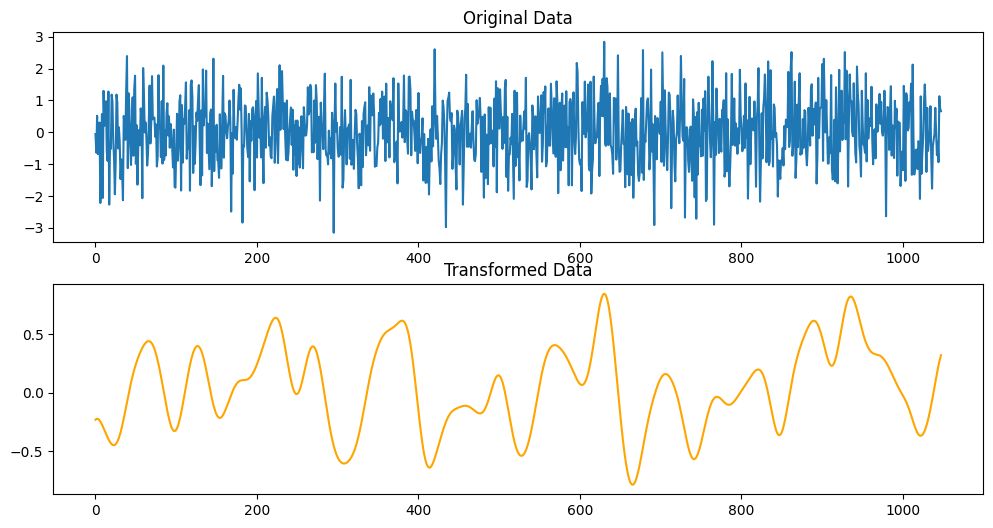

In [7]:
from utils.utils import filter

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(1048)

# fill the buffer with some noise
buffer.enqueue(np.random.normal(size=1048))

# define functions, arguments, and keyword arguments
functions = [multiply, filter]
args = [(), ()]
kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}] # filter parameters - order, cutoff frequency, type, and sampling frequency

# apply the transform method
result = buffer.transform(functions, args, kwargs)

import matplotlib.pyplot as plt
# plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(buffer.get_buffer(), label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(result, label='Transformed Data', color='orange')
plt.title('Transformed Data')

We can also use the special arguments ```"min"```, ```"max"```, ```"mean"```, and ```"std"``` to pass statistical properties of the signal as arguments to any of the functions. We can use this here, for example, to normalise our signal by diving by its maximum value.

Text(0.5, 1.0, 'Transformed Data')

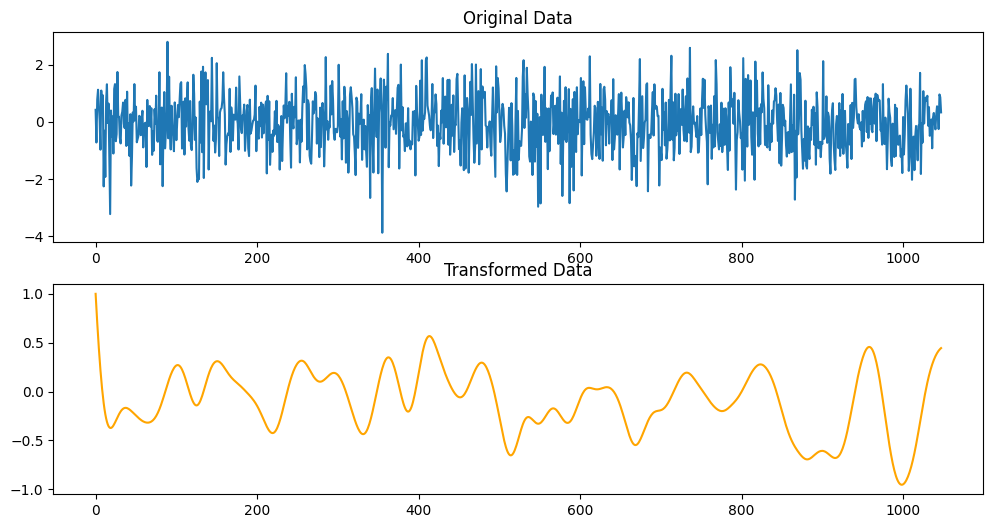

In [8]:
def divide(data, factor=2):
    return data / factor

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(1048)

# fill the buffer with some noise
buffer.enqueue(np.random.normal(size=1048))

# define functions, arguments, and keyword arguments
functions = [multiply, filter, divide]
args = [(), (), ()]
kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}, {"factor":"max"}]

# apply the transform method
result = buffer.transform(functions, args, kwargs)

import matplotlib.pyplot as plt
# plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(buffer.get_buffer(), label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(result, label='Transformed Data', color='orange')
plt.title('Transformed Data')

In the case that a function returns multiple values and we require a specific return value for the next function in the chain, we can also specify the output indices for each function.

Text(0.5, 1.0, 'Transformed Data')

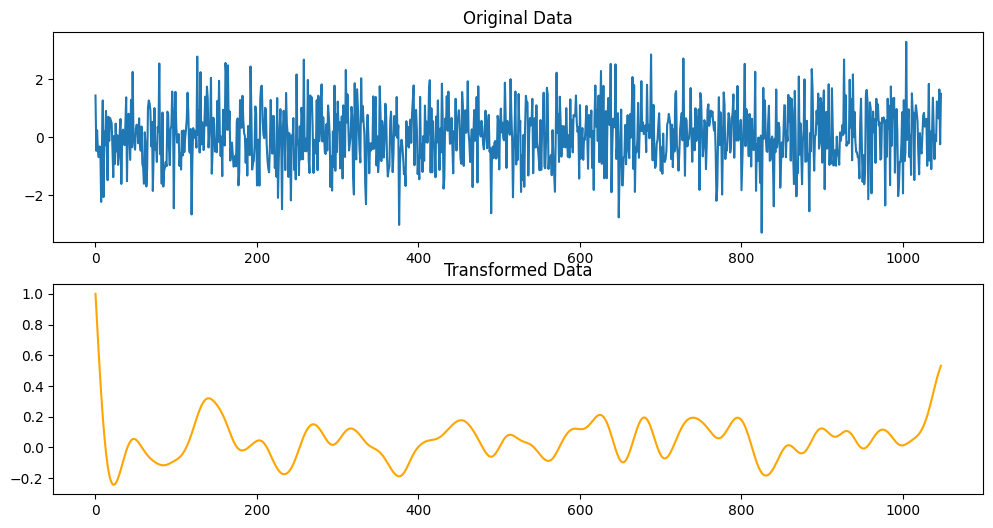

In [ ]:
def multiply(data, factor=2):
    return None, None, data* factor # add None for the first two outputs

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(1048)

# fill the buffer with some noise
buffer.enqueue(np.random.normal(size=1048))

# define functions, arguments, and keyword arguments
functions = [multiply, filter, divide]
args = [(), (), ()]
kwargs = [{"factor": 2}, {"order": 3, "cf": 5, "type": "low", "fs": 256}, {"factor":"max"}]

# specify output indices for each function
output_indices = [2, None, None]  # Use the third output of multiply, and all outputs of filter and divide

# apply the transform method
result = buffer.transform(functions, args, kwargs, output_indices=output_indices) # pass output_indices to the transform method

import matplotlib.pyplot as plt
# plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(buffer.get_buffer(), label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(result, label='Transformed Data', color='orange')
plt.title('Transformed Data')

It is important to note that the transform function returns a numpy array (in this case at least). So if you need the transform in a ```FIFOBuffer```, you will have to instantiate a new buffer and enqueue the result. This method for applying multiple functions appears is central to LightHearted, and appears in many other functions and objects.

#### 3.1.1 Transform Tick

When working with signals in real-time, timing becomes important. We don't want to be using computational resources to repeatedly perform transforms when no new data has arrived. Equally, we might only need to perform the transform at set time intervals. To aid in timing, the ```transform``` method has a variant ```transform_tick``` which can handle timing. The ```transform_tick``` method operates identically to the ```transform``` method. However, it can take two additional arguments. ```mode``` specifies whether the transform should take place when a new value is enqueued in the buffer (```"update"```) or at a set time inverval (```"time"```). In ```"time"``` mode, and additional argument ```"interval"``` can be passed, which specifies the update time in milliseconds. In the case that the function is called and the ticks requirements have not been met, the function returns ```None```. We can first demonstrate in ```"update"``` mode.

In [14]:
def multiply(data, factor=2):
    return data* factor

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [()]
kwargs = [{"factor": 2}]

# define some data to enqueue
data_to_enqueue = np.arange(90, 100)

# apply the transform method in a loop
for i, data in enumerate(data_to_enqueue):

    if i%2 == 0: # buffer doesn't update here
        # enqueue the data
        buffer.enqueue(data)
        print(f"Enqueued: {data}")
        
    # apply the transform method
    result = buffer.transform_tick(functions, args, kwargs, mode="update")
    print(f"Index: {i}, Data: {data}, Transformed Buffer: {result}")

Enqueued: 90
Index: 0, Data: 90, Transformed Buffer: [  2.   4.   6.   8.  10.  12.  14.  16.  18. 180.]
Index: 1, Data: 91, Transformed Buffer: None
Enqueued: 92
Index: 2, Data: 92, Transformed Buffer: [  4.   6.   8.  10.  12.  14.  16.  18. 180. 184.]
Index: 3, Data: 93, Transformed Buffer: None
Enqueued: 94
Index: 4, Data: 94, Transformed Buffer: [  6.   8.  10.  12.  14.  16.  18. 180. 184. 188.]
Index: 5, Data: 95, Transformed Buffer: None
Enqueued: 96
Index: 6, Data: 96, Transformed Buffer: [  8.  10.  12.  14.  16.  18. 180. 184. 188. 192.]
Index: 7, Data: 97, Transformed Buffer: None
Enqueued: 98
Index: 8, Data: 98, Transformed Buffer: [ 10.  12.  14.  16.  18. 180. 184. 188. 192. 196.]
Index: 9, Data: 99, Transformed Buffer: None


It is important to note here that even though the ```transform_tick``` method is called, internally it does not apply of the functions, saving computational resourses. This is useful while calling the function in ```while``` loops within async functions, as is the common use case in LightHearted scripts. We can also run this in ```"time"``` mode.

In [16]:
import time

# instiatiate a FIFOBuffer
buffer = FIFOBuffer(10)

# fill the buffer with some data
buffer.enqueue(np.arange(10))

# define functions, arguments, and keyword arguments
functions = [multiply]
args = [()]
kwargs = [{"factor": 2}]

# define some data to enqueue
data_to_enqueue = np.arange(90, 100)

# apply the transform method in a loop
now = time.perf_counter()
duration = 10

while time.perf_counter() - now <= duration:
    
    result = buffer.transform_tick(functions, args, kwargs, mode="time", interval=500) # 500 ms interval

    if result is not None:
        print(f"Time Elapsed: {time.perf_counter() - now:.2f} seconds, Transformed Buffer: {result}")

Time Elapsed: 0.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 0.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 1.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 1.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 2.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 2.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 3.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 3.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 4.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 4.50 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elapsed: 5.00 seconds, Transformed Buffer: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Time Elaps